## IMPORT DATASET

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('talep_data.xlsx', 'data', parse_dates=True, index_col='TARIH')

## PRE-PROCESSING

In [3]:
# Drop all the features except sales 
df.drop(['URUN_ID', 'URUN_GRUBU', 'STOK_DISI_SURE'], axis=1, inplace=True)

In [4]:
# Fill the missing date indices to capture all days (necessary for arima model otherwise gives warning)
date_range = pd.date_range('2017-01-01', '2019-11-30')
df = df.reindex(date_range)

In [5]:
df.head()

,SATIS_ADET
2017-01-01,2784.0
2017-01-02,10484.0
2017-01-03,8934.0
2017-01-04,10185.0
2017-01-05,13850.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1064 entries, 2017-01-01 to 2019-11-30
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SATIS_ADET  1031 non-null   float64
dtypes: float64(1)
memory usage: 16.6 KB


In [7]:
# Check for missing points
df.isnull().sum()

SATIS_ADET    33
dtype: int64

*  **Observation:** There are 33 missing sale values. Let's fill them by taking average of the previous and next sales.

In [8]:
# Fill the missing salese
df = df.interpolate()

In [9]:
# Interpolate row of 2018-12-28 which has sales value of zero
df.loc['2018-12-28']['SATIS_ADET'] = (df.loc['2018-12-27']['SATIS_ADET'] + df.loc['2018-12-29']['SATIS_ADET']) / 2

In [10]:
# Make sure there is no-missing values
df.isnull().sum()

SATIS_ADET    0
dtype: int64

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SATIS_ADET,1064.0,11551.81156,7207.831598,336.0,6299.5,10164.5,15609.0,57096.0


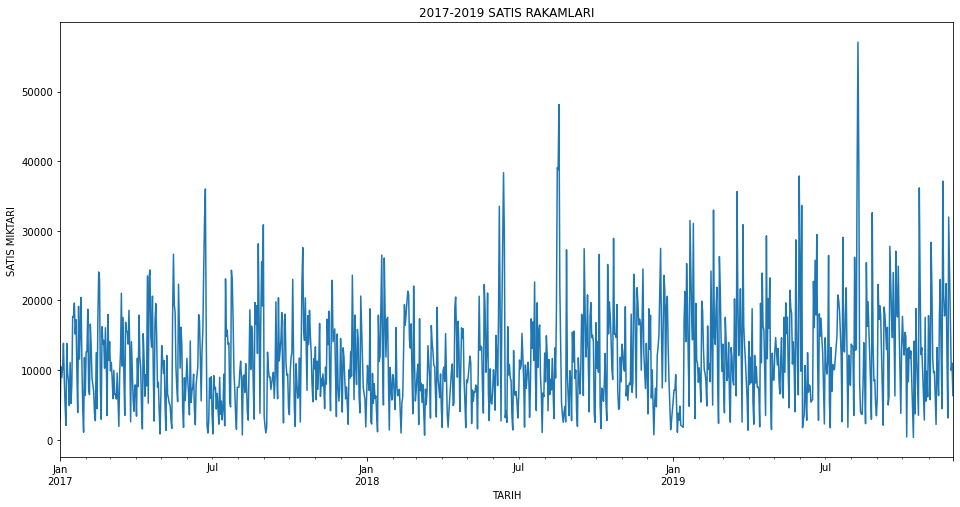

In [12]:
# Visualize the whole dataset
plt.figure(figsize=(16,8))
df['SATIS_ADET'].plot()
plt.title('2017-2019 SATIS RAKAMLARI')
plt.xlabel('TARIH')
plt.ylabel('SATIS MIKTARI')
plt.show()

## Stationarity Test

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
#Ho: Non stationary
#H1: Stationary

labels = ['Test Statistic','p-value','Number of Lags','Number of Observations']
results = adfuller(df)

for i in range(4):
    print(f'{labels[i]} : {results[i]}')

Test Statistic : -8.728909519392584
p-value : 3.23151656893952e-14
Number of Lags : 21
Number of Observations : 1042


Since p-value <= 0.05, there is strong evidence against the null hypothesis(Ho), reject the null hypothesis. 
Data is stationary

## Autocorrelation Plots

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

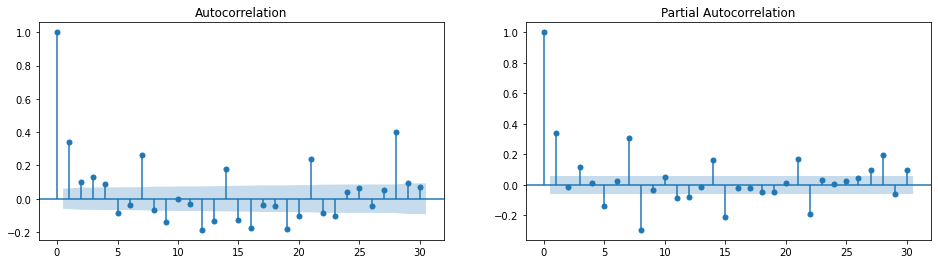

In [16]:
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1,2,1)
plot_acf(df, lags=30, ax=ax1)
ax2 = plt.subplot(1,2,2)
plot_pacf(df, lags=30, ax=ax2)
plt.show()

**OBSERVATION:** Both from the sales plot and these autocorrelation plots, I decided to choose the parameters of p-d-q:
*  p : number of lags = 15
*  d : differencing = 0 (since i didn't apply any)
*  q : moving Average for error terms = 2

## ARMA Model

In [17]:
from statsmodels.tsa.arima.model import ARIMA

In [18]:
model = ARIMA(df['SATIS_ADET'],order=(15,0,2))
model_fit = model.fit()

In [19]:
# Make predictions for the last known month sales (November 2019) and round them to integers
preds = round(model_fit.predict(start='2019-11-03',end='2019-11-30'))

In [20]:
results = pd.concat([df['SATIS_ADET'][-28:], preds], axis=1)
results.columns = ['true','pred']
results.head()

,true,pred
2019-11-03,5753.0,6741.0
2019-11-04,28358.0,19899.0
2019-11-05,22060.0,14781.0
2019-11-06,11687.0,14374.0
2019-11-07,9627.0,10883.0


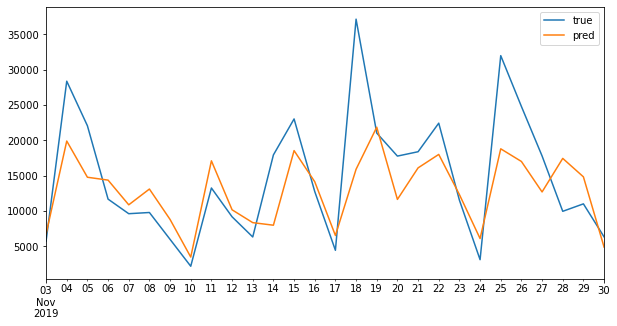

In [21]:
results.plot(figsize=(10,5))
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
mean_squared_error(results['true'], results['pred'], squared=False)

6422.639432952335

*  I didn't go beyond from this point since i tried machine learning models in the other notebook and they give better results than this. (I didn't use ARMA model to predict sales)